# Машинне навчання

## Опис

В цій лабораторній ви будете працювати з набором даних [UCI Wine Quality](https://archive.ics.uci.edu/dataset/186/wine+quality). 

## Підготовка

In [ ]:
%%capture
%pip install pandas seaborn scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

## Читання даних
В процессі читання даних ми додаємо 12-ту фічу - колір вина.

In [ ]:
# Завантажуємо червоне вино
dfr = pd.read_csv("https://gitlab.com/DmyMi/python-training-examples/-/raw/main/04.ml/data/winequality-red.csv", sep=';')
dfr['color'] = 'red'
# Завантажуємо біле вино
dfw = pd.read_csv("https://gitlab.com/DmyMi/python-training-examples/-/raw/main/04.ml/data/winequality-white.csv", sep=';')
dfw['color'] = 'white'
# Об’єднання та перемішування даних
df = pd.concat([dfr, dfw])
df = df.sample(frac=1, random_state=3).reset_index(drop=True)

## Огляд даних

In [ ]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,5.9,0.180,0.28,1.0,0.037,24.0,88.0,0.99094,3.29,0.55,10.65,7,white
1,10.2,0.670,0.39,1.9,0.054,6.0,17.0,0.99760,3.17,0.47,10.00,5,red
2,8.4,0.715,0.20,2.4,0.076,10.0,38.0,0.99735,3.31,0.64,9.40,5,red
3,6.8,0.370,0.51,11.8,0.044,62.0,163.0,0.99760,3.19,0.44,8.80,5,white
4,8.9,0.750,0.14,2.5,0.086,9.0,30.0,0.99824,3.34,0.64,10.50,5,red


Кількісний розподіл якості вина:

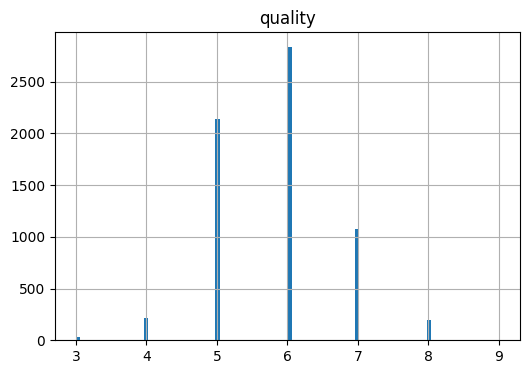

In [ ]:
df.hist('quality', bins=100, figsize=(6, 4));

Додамо колонку "клас" для подальшої класифікації:

In [ ]:
df['class'] = df.quality.apply(lambda x: "high" if x > 6 else "low")

Візуалізація багатовимірних зв’язків між зразками:

> Примітка: візуалізація може зайняти 1-2 хвилини

In [ ]:
##sns.pairplot(df.drop('quality', axis=1), hue='class', height=2.5);

Як видно, багато фіч є корельованими, що також можна побачити за допомогою матриці кореляції:

In [ ]:
from matplotlib import colors
import matplotlib.pyplot as plt

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    Code by Joe Kington
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

def background_gradient(s, cmap='bwr', low=0, high=0):
    """
    Color correlations table according to specified colormap
    """
    rng = s.max() - s.min()
    norm = MidpointNormalize(s.min() - (rng * low), s.max() + (rng * high), 0)
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.colormaps.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

df.drop(['color', 'class'], axis=1).corr().style.apply(background_gradient, axis=1).format(precision=2).set_properties(**{'color': 'black'})

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.00,0.22,0.32,-0.11,0.30,-0.28,-0.33,0.46,-0.25,0.30,-0.10,-0.08
volatile acidity,0.22,1.00,-0.38,-0.20,0.38,-0.35,-0.41,0.27,0.26,0.23,-0.04,-0.27
citric acid,0.32,-0.38,1.00,0.14,0.04,0.13,0.20,0.10,-0.33,0.06,-0.01,0.09
residual sugar,-0.11,-0.20,0.14,1.00,-0.13,0.40,0.50,0.55,-0.27,-0.19,-0.36,-0.04
chlorides,0.30,0.38,0.04,-0.13,1.00,-0.20,-0.28,0.36,0.04,0.40,-0.26,-0.20
free sulfur dioxide,-0.28,-0.35,0.13,0.40,-0.20,1.00,0.72,0.03,-0.15,-0.19,-0.18,0.06
total sulfur dioxide,-0.33,-0.41,0.20,0.50,-0.28,0.72,1.00,0.03,-0.24,-0.28,-0.27,-0.04
density,0.46,0.27,0.10,0.55,0.36,0.03,0.03,1.00,0.01,0.26,-0.69,-0.31
pH,-0.25,0.26,-0.33,-0.27,0.04,-0.15,-0.24,0.01,1.00,0.19,0.12,0.02
sulphates,0.30,0.23,0.06,-0.19,0.40,-0.19,-0.28,0.26,0.19,1.00,-0.00,0.04


## Лінійна регресія

> Примітка: Залежність якості вина від інших розглянутих фіч є (скоріш за все) нелінійною. Тому точність моделі в цьому завданні буде невеликою.

**Завдання 1**: Відокремте цільове значення `quality`, розділіть дані у співвідношенні 7:3 (30% - набір для тестування, використовуйте `random_state=42`) і попередньо обробіть дані за допомогою `StandardScaler`.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

regression_df = df.drop(['color', 'class'], axis=1)

X = regression_df.drop(['quality'], axis=1)
y = regression_df.quality

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Завдання 2**: Навчіть модель LASSO з $\alpha = 0,01$ (слабка регулярізація) і масштабованими даними. Знову встановіть `random_state=42`

In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.01, random_state=42)

lasso.fit(X_train_scaled, y_train)




Lasso(alpha=0.01, random_state=42)

Відсортуйте фічі за їх впливом на цільове значення (якість вина). Майте на увазі, що як великі позитивні, так і великі негативні коефіцієнти означають великий вплив на цільове значення. Тут зручно використовувати `pandas.DataFrame`.

**Завдання 3**: Яка фіча є найменш інформативною для прогнозування якості вина, згідно з цією моделлю LASSO?

In [ ]:
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lasso.coef_})
sorted_features = feature_importance.reindex(feature_importance['Coefficient'].abs().sort_values(ascending=False).index)

print("Features sorted by importance:\n", sorted_features)

print("\nLeast important features are: ")
print(sorted_features[sorted_features['Coefficient'] == 0])

Features sorted by importance:
                  Feature  Coefficient
10               alcohol     0.381063
1       volatile acidity    -0.219966
6   total sulfur dioxide    -0.093599
3         residual sugar     0.084090
9              sulphates     0.078756
5    free sulfur dioxide     0.067353
4              chlorides    -0.031296
8                     pH     0.021105
0          fixed acidity     0.007132
2            citric acid    -0.000000
7                density    -0.000000

Least important features are: 
       Feature  Coefficient
2  citric acid         -0.0
7      density         -0.0


**Завдання 4**: Навчіть `LassoCV` із `random_state=42`, щоб вибрати найкраще значення $\alpha$ у 5-кратній перехресній перевірці. Скористайтесь масштабованими даними.

In [ ]:
from sklearn.linear_model import LassoCV

alphas = np.logspace(-6, 2, 200)
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)
best_alpha = lasso_cv.alpha_
print("Best alpha: {:.10f}".format(best_alpha))

Best alpha: 0.0000010000


**Завдання 5**: Яка фіча є найменш інформативною для прогнозування якості вина, згідно налаштованої моделі LASSO?

In [ ]:
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lasso_cv.coef_})
sorted_features = feature_importance.reindex(feature_importance['Coefficient'].abs().sort_values(ascending=False).index)

print("Features sorted by importance:\n", sorted_features)

print("\nLeast important feature is: ")
print(sorted_features[-1:])

Features sorted by importance:
                  Feature  Coefficient
10               alcohol     0.313426
1       volatile acidity    -0.223555
3         residual sugar     0.205159
7                density    -0.167361
6   total sulfur dioxide    -0.141996
0          fixed acidity     0.109289
9              sulphates     0.107710
5    free sulfur dioxide     0.099497
8                     pH     0.081632
4              chlorides    -0.031275
2            citric acid    -0.019449

Least important feature is: 
       Feature  Coefficient
2  citric acid    -0.019449


**Завдання 6**: Які середнь- квадратичні помилки прогнозування налаштованої моделі LASSO на тренувальному і тестовому наборах даних? Скористайтесь масштабованими даними.

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred_train_lasso = lasso.predict(X_train_scaled)
y_pred_test_lasso = lasso.predict(X_test_scaled)


mse_train_lasso = mean_squared_error(y_train, y_pred_train_lasso)
mse_test_lasso = mean_squared_error(y_test, y_pred_test_lasso)

print("For Lasso:");
print("Mean squared error (train): %.3f" % mse_train_lasso) # Ваше рішення
print("Mean squared error (test): %.3f" % mse_test_lasso) # Ваше рішення

y_pred_train_lasso_cv = lasso_cv.predict(X_train_scaled)
y_pred_test_lasso_cv  = lasso_cv.predict(X_test_scaled)


mse_train_lasso_cv = mean_squared_error(y_train, y_pred_train_lasso_cv)
mse_test_lasso_cv = mean_squared_error(y_test, y_pred_test_lasso_cv)

print("For LassoCV:");
print("Mean squared error (train): %.3f" % mse_train_lasso_cv ) # Ваше рішення
print("Mean squared error (test): %.3f" % mse_test_lasso_cv ) # Ваше рішення

For Lasso:
Mean squared error (train): 0.536
Mean squared error (test): 0.560
For LassoCV:
Mean squared error (train): 0.532
Mean squared error (test): 0.559


## Класифікація

**Завдання 7**: Відокремте цільове значення `class`, розділіть дані у співвідношенні 7:3 (30% - набір для тестування, використовуйте `random_state=42`) і попередньо обробіть дані за допомогою `StandardScaler`.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

tree_df = df.drop(['color', 'quality'], axis=1)

X = tree_df.drop(['class'], axis=1)
y = tree_df[['class']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



**Завдання 8**: Навчіть дерево рішень (`random_state=42`). Знайдіть оптимальну максимальну глибину за допомогою 5-кратної перехресної перевірки (`GridSearchCV`). Скористайтесь масштабованими даними.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X_train_scaled, y_train)

tree_predictions = tree.predict(X_test_scaled)
print("Tree accuracy with max_depth=3: {}".format(accuracy_score(y_test, tree_predictions)));

tree_params = {"max_depth": range(2, 11)}
best_tree = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)
best_tree.fit(X_train_scaled, y_train)
print("Best params:", best_tree.best_params_)
print("Best cross validaton score", best_tree.best_score_)



Tree accuracy with max_depth=3: 0.8005128205128205
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best params: {'max_depth': 6}
Best cross validaton score 0.8299955270252299


**Завдання 9**: Навчіть дерево рішень із кращою максимальною глибиною `max_depth` яку ви отримаєте у попередньому кроці і обчисліть точність на тестовому набору. Використовуйте параметр `random_state = 42` для відтворюваності. Скористайтесь масштабованими даними.

In [ ]:
from sklearn.metrics import accuracy_score


tuned_tree = DecisionTreeClassifier(max_depth=6, random_state=42)
tuned_tree.fit(X_train_scaled, y_train)
tuned_tree_predictions = tuned_tree.predict(X_test_scaled)
print("Tree accuracy with max_depth=6: {}".format(accuracy_score(y_test, tuned_tree_predictions)));

Tree accuracy with max_depth=6: 0.8148717948717948


## Зменшення розмірності

Ми знаємо що дані у нас достатньо корельовані, тому ми можемо зменшити кількість фіч при цьому зберігаючи достатню різноманітність даних.

**Завдання 10**: Відокремте цільове значення `class` і попередньо обробіть дані за допомогою `StandardScaler`. Розділяти дані немає необхідності, оскільки ми в подальшому будемо використовувати кластеризацію.

In [ ]:
from sklearn.preprocessing import StandardScaler

cluster_df = df.drop(['color', 'quality'], axis=1)

X = cluster_df.drop(['class'], axis=1)
y = cluster_df[['class']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Завдання 11**: Зменшіть кількість вимірів за допомогою PCA, залишивши стільки компонентів, скільки необхідно для пояснення принаймні 90% дисперсії вихідних (масштабованих) даних. Використовуйте масштабований набір даних і `random_state=42`.

In [ ]:
from sklearn.decomposition import PCA

# Ваше рішення
# pca =
# X_pca =

pca = PCA(n_components=0.90, random_state=42)
X_pca = pca.fit_transform(X_scaled)


**Завдання 12**: Яка мінімальна кількість головних компонентів потрібна для покриття 90% дисперсії вихідних (масштабованих) даних?

In [ ]:
num_components = pca.n_components_
print("Number of Components after PCA to cover 90% of variance: {}. Initial was: {}".format(num_components,X_scaled.shape[1]))

Number of Components after PCA to cover 90% of variance: 7. Initial was: 11


**Завдання 13**: Який відсоток дисперсії покриває перший головний компонент? Округліть до найближчого відсотка.

In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_

variance_first_component = explained_variance_ratio[0] * 100
print("First component covers: {}% of initial variance".format(round(variance_first_component,2)))

First component covers: 27.54% of initial variance


**Завдання 14**: Візуалізуйте дані в проекції на перші два основні компоненти. Використайте `Seaborn`.

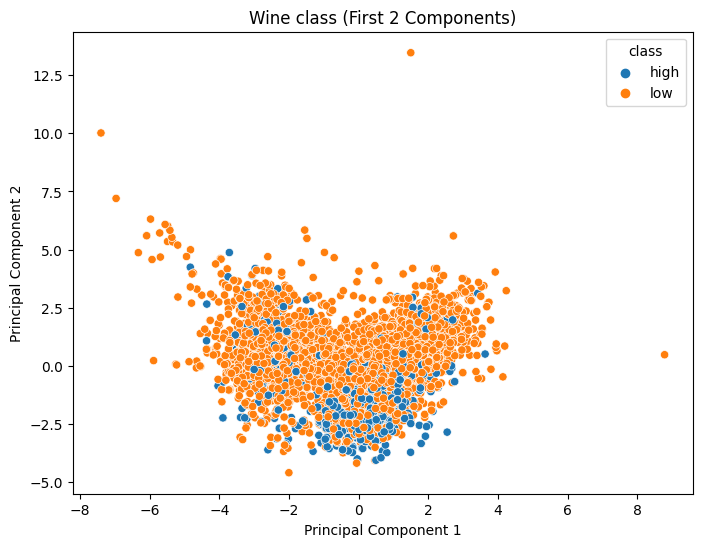

In [ ]:
# Ваше рішення
# sns.scatterplot(x= , y= , hue=y.values);
import matplotlib.pyplot as plt
# Plotting using seaborn scatterplot
plt.figure(figsize=(8, 6))

pca_df_for_scatterplot = pd.DataFrame(X_pca[:, :2], columns=["PC1", "PC2"])
pca_df_for_scatterplot["class"]=y
pca_df_for_scatterplot.head()

sns.scatterplot(x="PC1", y="PC2", hue="class", data=pca_df_for_scatterplot)
plt.title('Wine class (First 2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='class', loc='best')
plt.show()



Ви побачите якусь кількість кластерів, але можливо побачене вас не втішить :)

## Кластеризація
**Завдання 14**: Виконайте кластеризацію за допомогою методу `KMeans`, навчаючи модель на даних зі зменшеною розмірністю (за допомогою PCA). У цьому випадку ми шукаємо рівно 2 кластери (оскільки ми знаємо що у нас два класи), але в загальному випадку ми не будемо знати, скільки кластерів нам слід шукати.

Опції:
- `n_clusters` = 2 (кількість унікальних міток цільового класу)
- `n_init` = 100
- `random_state` = 42 (для відтворюваності результату)

Інші параметри повинні мати значення за замовчуванням.

In [ ]:
from sklearn.cluster import KMeans

# Ваше рішення
# kmeans = # Ваше рішення
# kmeans.fit # Ваше рішення
# cluster_labels = # Ваше рішення

kmeans = KMeans(n_clusters=2, n_init = 100, random_state=42)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_



**Завдання 15**: Візуалізуйте дані в проекції на перші два основні компоненти. Розфарбуйте точки відповідно до отриманих кластерів.

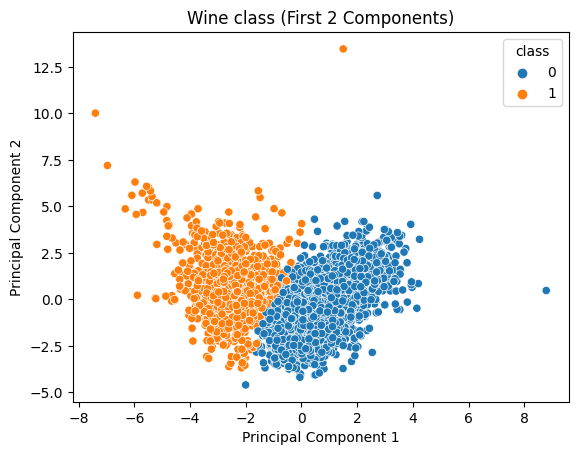

In [ ]:
pca_df_for_scatterplot = pd.DataFrame(X_pca[:, :2], columns=["PC1", "PC2"])
pca_df_for_scatterplot["class"]=y
pca_df_for_scatterplot.head()

sns.scatterplot(x="PC1", y="PC2", hue=cluster_labels, data=pca_df_for_scatterplot)
plt.title('Wine class (First 2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='class', loc='best')
plt.show()

Подивіться на відповідність між позначками кластера та початковими мітками класу, а також на те, як їх плутає `KMeans` :)

In [ ]:

tab = pd.crosstab(y['class'], cluster_labels, margins=True)
tab.index = [
    "high",
    "low",
    "all",
]
tab.columns = ["cluster" + str(i + 1) for i in range(2)] + ["all"]
tab

print(tab.to_string(index=False))

 cluster1  cluster2  all
     1062       215 1277
     3787      1433 5220
     4849      1648 6497


Ми бачимо, що для кожного класу є кілька кластерів. Давайте розглянемо максимальний відсоток об’єктів у класі, які віднесли до одного кластеру. Це буде проста метрика, яка характеризує, наскільки легко клас відокремлюється від інших під час кластеризації.

Приклад: якщо для класу «high» (з 1277 екземплярами, що належать до нього), розподіл кластерів є:
  - кластер 1 - 1062
  - кластер 3 - 215

то така частка буде 1062/1277 $ \approx $ 0,83.

**Завдання 16**: Який клас відокремлений краще на основі простого показника, описаного вище?

In [ ]:
tab['proportion_cluster1'] = tab['cluster1'] / tab['all'] * 100
tab['proportion_cluster2'] = tab['cluster2'] / tab['all'] * 100

print(tab)
print()
print("Class 'high' is separated better!")


      cluster1  cluster2   all  proportion_cluster1  proportion_cluster2
high      1062       215  1277            83.163665            16.836335
low       3787      1433  5220            72.547893            27.452107
all       4849      1648  6497            74.634447            25.365553

Class 'high' is separated better!


Можна побачити, що kMeans не дуже добре розрізняє класи. Давайте дізнаємось чи PCA допоможе класифікації (оскільки ми знаємо класи).

**Завдання 17**: Навчіть дерево рішень (`random_state=42`). Знайдіть оптимальну максимальну глибину за допомогою 5-кратної перехресної перевірки (`GridSearchCV`). Скористайтесь даними зі зменшеною розмірністю (за допомогою PCA).

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA
pca = PCA(n_components=0.90, random_state=42)
X_pca = pca.fit_transform(X_train_scaled)
X_pca_test = pca.transform(X_test_scaled)

# DecisionTreeClassifier, max_depth=3
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X_pca, y_train)
tree_predictions = tree.predict(X_pca_test)
print("Tree accuracy with max_depth=3: {}".format(accuracy_score(y_test, tree_predictions)));

tree_params = {"max_depth": range(2, 11)}

# GridSearchCV, cv=5
best_tree = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)
best_tree.fit(X_pca, y_train)
print("Best params:", best_tree.best_params_)
print("Best cross validaton score", best_tree.best_score_)

# DecisionTreeClassifier, max_depth=4
tuned_tree = DecisionTreeClassifier(max_depth=4, random_state=42)
tuned_tree.fit(X_pca, y_train)
tuned_tree_predictions = tuned_tree.predict(X_pca_test)
print("Tree accuracy with max_depth=4: {}".format(accuracy_score(y_test, tuned_tree_predictions)));

Tree accuracy with max_depth=3: 0.7974358974358975
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best params: {'max_depth': 4}
Best cross validaton score 0.8038278992734439
Tree accuracy with max_depth=6: 0.798974358974359


Загалом, ситуація не покращилась (або стало гірше). Але (сподіваюсь) стало зрозуміло, що конкретні алгоритми машинного навчання не можна застосувати для рішення всіх задач, і вихідний набір даних впливає їх ефективність.

Тому, дуже часто треба або перебирати різні алгоритми в пошуках того, який краще вирішить задачу або використовувати методи фіча інжинірінгу для допомоги (про що ми поговоримо на наступних лекціях).